In [1]:
#The following code is related to autoencoders
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
#Desining the data loader
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_paths[idx])
        image = cv2.imread(img_name , cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            image = self.transform(image)
            
        return image
    
    
class ToCudaTransform(object):
    def __call__(self, tensor):
        if torch.cuda.is_available():
            return tensor.to(torch.device("cuda"))
        else:
            return tensor

        
root_dir = r"C:\Deep-RRT-Star-Implementation-main-1\arena_images"
transform = transforms.Compose([
    transforms.ToTensor(),
    ToCudaTransform()  # Add custom transform to move tensor to CUDA
])

custom_dataset = CustomDataset(root_dir=root_dir, transform=transform)

data_loader = DataLoader(custom_dataset, batch_size=10, shuffle=True, drop_last=True)


# images , names = next(iter(data_loader))

# image = images[0]


# image = image.numpy()

# image = np.transpose(image, (1, 2, 0))

# print(names)
# plt.imshow(image)

In [30]:
# validation_dataset = CustomDataset(root_dir=r'C:\Deep-RRT-Star-Implementation-main-1\validation_images', transform=transform)
# validation_loader = DataLoader(validation_dataset , batch_size = 15 , shuffle = False , drop_last = True)

In [3]:
#Designing the encoder decoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64 , 128 , 3 , stride = 2 , padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 , 256 , 3 , stride = 2 , padding = 1),
            nn.ReLU(),
            nn.Conv2d(256 , 512 , 3 , stride = 2 , padding = 1),
            nn.ReLU(),
            nn.Conv2d(512 , 1024 , 2),
            nn.ReLU(),
            nn.Conv2d(1024 , 2048 , 1),
            nn.ReLU(),
            nn.Conv2d(2048 , 28 , 1)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(28, 2048, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 1024, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256,  3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    

In [4]:
mse_loss = nn.MSELoss()
lam=1e-2
def loss_function_training(W, x, recons_x, h):
    mse = mse_loss(recons_x, x)
    # Since: W is shape of N_hidden x N. So, we do not need to transpose it as
    # opposed to #1
    dh = h * (1 - h) # Hadamard product produces size N_batch x N_hidden
#     print('dh shape')
#     print(dh.shape)
    # Sum through the input dimension to improve efficiency, as suggested in #1
    w_sum = torch.sum(Variable(W)**2, dim=1)
#     print('w_sum shape')
#     print(w_sum.shape)
    # unsqueeze to avoid issues with torch.mv
    w_sum = w_sum.unsqueeze(1) # shape N_hidden x 1
    contractive_loss = torch.sum(torch.mm(dh**2, w_sum), 0)
    return mse + contractive_loss.mul_(lam)

def loss_function_validation(W , x, recons_x, h):
    mse = mse_loss(recons_x , x)
    return mse
    

In [5]:
autoencoder = Autoencoder()
if torch.cuda.is_available():
    autoencoder = autoencoder.to(torch.device("cuda"))

In [6]:
#writing the training loop. This the training loop without early stopping
num_epochs = 1000
outputs = []
params = list(autoencoder.parameters())
optimizer = torch.optim.Adagrad(params)
best_loss = float('inf')  
patience = 10  # Define patience for early stopping
counter = 0  # Counter to track epochs without improvement

for epoch in range(num_epochs):
    for (img) in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        h = autoencoder.encoder(img)
#         print('h before conversion')
#         print(h.shape)
        recon = autoencoder.decoder(h)
        encoder_state_dict = autoencoder.encoder.state_dict()
#         print(encoder_state_dict)
        encoder_keys = encoder_state_dict.keys()
        #print(encoder_keys)
        W = encoder_state_dict['16.weight']
#         print('W shape before conversion')
#         print(W.shape)
        W = W.view(28 , -1)
#         print('W shape after conversion')
#         print(W.shape)
#         print('h after conversion')
        h = h.view(10, -1)
#         print(h.shape)
        loss = loss_function_training(W ,img ,recon , h)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model_path='model_'+str(epoch)+'.pkl'
    save_path = r"C:\Trained_CAE_weights_2"
    path = os.path.join(save_path , model_path)
    torch.save(autoencoder.encoder.state_dict(),path)

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))
    
    
torch.save(autoencoder.encoder.state_dict(), r'C:\Users\Navdeep\Downloads\cae_encoder3.pkl')

Epoch:1, Loss:0.0791
Epoch:2, Loss:0.0046
Epoch:3, Loss:0.0028
Epoch:4, Loss:0.0021
Epoch:5, Loss:0.0018
Epoch:6, Loss:0.0014
Epoch:7, Loss:0.0012
Epoch:8, Loss:0.0010
Epoch:9, Loss:0.0009
Epoch:10, Loss:0.0009
Epoch:11, Loss:0.0007
Epoch:12, Loss:0.0007
Epoch:13, Loss:0.0006
Epoch:14, Loss:0.0004
Epoch:15, Loss:0.0004
Epoch:16, Loss:0.0003
Epoch:17, Loss:0.0003
Epoch:18, Loss:0.0003
Epoch:19, Loss:0.0003
Epoch:20, Loss:0.0002
Epoch:21, Loss:0.0002
Epoch:22, Loss:0.0002
Epoch:23, Loss:0.0002
Epoch:24, Loss:0.0002
Epoch:25, Loss:0.0002
Epoch:26, Loss:0.0002
Epoch:27, Loss:0.0002
Epoch:28, Loss:0.0002
Epoch:29, Loss:0.0001
Epoch:30, Loss:0.0001
Epoch:31, Loss:0.0001
Epoch:32, Loss:0.0001
Epoch:33, Loss:0.0001
Epoch:34, Loss:0.0001
Epoch:35, Loss:0.0001
Epoch:36, Loss:0.0001
Epoch:37, Loss:0.0001
Epoch:38, Loss:0.0001
Epoch:39, Loss:0.0001
Epoch:40, Loss:0.0001
Epoch:41, Loss:0.0001
Epoch:42, Loss:0.0001
Epoch:43, Loss:0.0001
Epoch:44, Loss:0.0001
Epoch:45, Loss:0.0001
Epoch:46, Loss:0.00

KeyboardInterrupt: 

In [34]:
#This is the training loop which incoporates early stopping
import os
num_epochs = 3000
outputs = []
params = list(autoencoder.parameters())
optimizer = torch.optim.Adagrad(params)
best_loss = float('inf')  
patience = 100  # Define patience for early stopping
counter = 0  # Counter to track epochs without improvement

for epoch in range(num_epochs):
    for (img) in data_loader:
        h = autoencoder.encoder(img)
        recon = autoencoder.decoder(h)
        encoder_state_dict = autoencoder.encoder.state_dict()
        W = encoder_state_dict['16.weight']
        W = W.view(28 , -1)
        h = h.view(10, -1)
        loss = loss_function_training(W ,img ,recon , h)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))
    model_path='model_'+str(epoch)+'.pkl'
    save_path = r'C:\Trained_CAE_weights'
    path = os.path.join(save_path , model_path)
    torch.save(autoencoder.encoder.state_dict(),path)
    
    
    # Validation loss calculation and early stopping check
    with torch.no_grad():
        # Calculate validation loss
        validation_loss = 0
        for (val_img) in validation_loader:
            val_h = autoencoder.encoder(val_img)
            val_recon = autoencoder.decoder(val_h)
            val_encoder_state_dict = autoencoder.encoder.state_dict()
            val_W = val_encoder_state_dict['16.weight']
            val_W = val_W.view(28 , -1)
            val_h = val_h.view(10, -1)
            val_loss = loss_function_validation(val_W ,val_img ,val_recon , val_h)
            validation_loss += val_loss.item()
        validation_loss /= len(validation_loader)
#         print('validation_loader_length')
#         print(len(validation_loader))
        print(f'Epoch:{epoch + 1}, Validation Loss:{validation_loss:.4f}')
        # Check if validation loss has improved
#         if validation_loss < best_loss:
#             best_loss = validation_loss
#             counter = 0
#             # Optionally, you can save the model here if you want to keep track of the best model
        #torch.save(autoencoder.encoder.state_dict(), r'C:\Deep-RRT-Star-Implementation-main-1\model_after_validation_loss\cae_encoder_val.pkl')
#         else:
#             counter += 1
        
#         # Check for early stopping
#         if counter >= patience:
#             print(f'Early stopping at epoch {epoch+1} as validation loss did not improve for {patience} epochs.')
#             break
            
# Optionally, you can save the final model after training completes
# torch.save(autoencoder.encoder.state_dict(), 'final_model.pth')


Epoch:1, Loss:0.2488
Epoch:1, Validation Loss:0.2476
Epoch:2, Loss:0.2373
Epoch:2, Validation Loss:0.2427
Epoch:3, Loss:0.2358
Epoch:3, Validation Loss:0.2286
Epoch:4, Loss:0.2110
Epoch:4, Validation Loss:0.2347
Epoch:5, Loss:0.2181
Epoch:5, Validation Loss:0.2255
Epoch:6, Loss:0.1831
Epoch:6, Validation Loss:0.2252
Epoch:7, Loss:0.1917
Epoch:7, Validation Loss:0.2268
Epoch:8, Loss:0.2036
Epoch:8, Validation Loss:0.2237
Epoch:9, Loss:0.2390
Epoch:9, Validation Loss:0.2232
Epoch:10, Loss:0.2291
Epoch:10, Validation Loss:0.2278
Epoch:11, Loss:0.2091
Epoch:11, Validation Loss:0.2229
Epoch:12, Loss:0.2350
Epoch:12, Validation Loss:0.2238
Epoch:13, Loss:0.1859
Epoch:13, Validation Loss:0.2245
Epoch:14, Loss:0.2103
Epoch:14, Validation Loss:0.2225
Epoch:15, Loss:0.2216
Epoch:15, Validation Loss:0.2215
Epoch:16, Loss:0.2297
Epoch:16, Validation Loss:0.2207
Epoch:17, Loss:0.2192
Epoch:17, Validation Loss:0.2218
Epoch:18, Loss:0.2172
Epoch:18, Validation Loss:0.2205
Epoch:19, Loss:0.1963
Epoch:

Epoch:149, Loss:0.1609
Epoch:149, Validation Loss:0.2293
Epoch:150, Loss:0.1605
Epoch:150, Validation Loss:0.2321
Epoch:151, Loss:0.1680
Epoch:151, Validation Loss:0.2291
Epoch:152, Loss:0.1831
Epoch:152, Validation Loss:0.2327
Epoch:153, Loss:0.1880
Epoch:153, Validation Loss:0.2359
Epoch:154, Loss:0.1540
Epoch:154, Validation Loss:0.2388
Epoch:155, Loss:0.1692
Epoch:155, Validation Loss:0.2384
Epoch:156, Loss:0.1518
Epoch:156, Validation Loss:0.2334
Epoch:157, Loss:0.1231
Epoch:157, Validation Loss:0.2444
Epoch:158, Loss:0.1320
Epoch:158, Validation Loss:0.2320
Epoch:159, Loss:0.1583
Epoch:159, Validation Loss:0.2424
Epoch:160, Loss:0.1564
Epoch:160, Validation Loss:0.2361
Epoch:161, Loss:0.1497
Epoch:161, Validation Loss:0.2307
Epoch:162, Loss:0.1627
Epoch:162, Validation Loss:0.2311
Epoch:163, Loss:0.1760
Epoch:163, Validation Loss:0.2380
Epoch:164, Loss:0.1360
Epoch:164, Validation Loss:0.2320
Epoch:165, Loss:0.1636
Epoch:165, Validation Loss:0.2357
Epoch:166, Loss:0.1658
Epoch:16

Epoch:293, Loss:0.1172
Epoch:293, Validation Loss:0.2868
Epoch:294, Loss:0.1307
Epoch:294, Validation Loss:0.2851
Epoch:295, Loss:0.1147
Epoch:295, Validation Loss:0.2869
Epoch:296, Loss:0.1031
Epoch:296, Validation Loss:0.2988
Epoch:297, Loss:0.1078
Epoch:297, Validation Loss:0.2824
Epoch:298, Loss:0.1195
Epoch:298, Validation Loss:0.2911
Epoch:299, Loss:0.1089
Epoch:299, Validation Loss:0.2937
Epoch:300, Loss:0.1102
Epoch:300, Validation Loss:0.2781
Epoch:301, Loss:0.1207
Epoch:301, Validation Loss:0.2914
Epoch:302, Loss:0.1338
Epoch:302, Validation Loss:0.2867
Epoch:303, Loss:0.1291
Epoch:303, Validation Loss:0.2855
Epoch:304, Loss:0.1056
Epoch:304, Validation Loss:0.2866
Epoch:305, Loss:0.1137
Epoch:305, Validation Loss:0.2941
Epoch:306, Loss:0.1098
Epoch:306, Validation Loss:0.2890
Epoch:307, Loss:0.1123
Epoch:307, Validation Loss:0.2980
Epoch:308, Loss:0.1023
Epoch:308, Validation Loss:0.2949
Epoch:309, Loss:0.1096
Epoch:309, Validation Loss:0.2994
Epoch:310, Loss:0.1286
Epoch:31

Epoch:437, Loss:0.0756
Epoch:437, Validation Loss:0.3290
Epoch:438, Loss:0.0895
Epoch:438, Validation Loss:0.3303
Epoch:439, Loss:0.0817
Epoch:439, Validation Loss:0.3284
Epoch:440, Loss:0.0774
Epoch:440, Validation Loss:0.3226
Epoch:441, Loss:0.0538
Epoch:441, Validation Loss:0.3240
Epoch:442, Loss:0.0558
Epoch:442, Validation Loss:0.3315
Epoch:443, Loss:0.0437
Epoch:443, Validation Loss:0.3264
Epoch:444, Loss:0.0869
Epoch:444, Validation Loss:0.3364
Epoch:445, Loss:0.1083
Epoch:445, Validation Loss:0.3366
Epoch:446, Loss:0.0804
Epoch:446, Validation Loss:0.3324
Epoch:447, Loss:0.1003
Epoch:447, Validation Loss:0.3258
Epoch:448, Loss:0.0830
Epoch:448, Validation Loss:0.3292
Epoch:449, Loss:0.0973
Epoch:449, Validation Loss:0.3312
Epoch:450, Loss:0.0624
Epoch:450, Validation Loss:0.3278
Epoch:451, Loss:0.0850
Epoch:451, Validation Loss:0.3332
Epoch:452, Loss:0.0773
Epoch:452, Validation Loss:0.3280
Epoch:453, Loss:0.0827
Epoch:453, Validation Loss:0.3328
Epoch:454, Loss:0.0724
Epoch:45

Epoch:581, Loss:0.0561
Epoch:581, Validation Loss:0.3564
Epoch:582, Loss:0.0622
Epoch:582, Validation Loss:0.3677
Epoch:583, Loss:0.0581
Epoch:583, Validation Loss:0.3617
Epoch:584, Loss:0.0553
Epoch:584, Validation Loss:0.3599
Epoch:585, Loss:0.0471
Epoch:585, Validation Loss:0.3657
Epoch:586, Loss:0.0584
Epoch:586, Validation Loss:0.3647
Epoch:587, Loss:0.0531
Epoch:587, Validation Loss:0.3613
Epoch:588, Loss:0.0597
Epoch:588, Validation Loss:0.3656
Epoch:589, Loss:0.0485
Epoch:589, Validation Loss:0.3621
Epoch:590, Loss:0.0466
Epoch:590, Validation Loss:0.3573
Epoch:591, Loss:0.0488
Epoch:591, Validation Loss:0.3611
Epoch:592, Loss:0.0460
Epoch:592, Validation Loss:0.3616
Epoch:593, Loss:0.0569
Epoch:593, Validation Loss:0.3647
Epoch:594, Loss:0.0510
Epoch:594, Validation Loss:0.3575
Epoch:595, Loss:0.0535
Epoch:595, Validation Loss:0.3540
Epoch:596, Loss:0.0475
Epoch:596, Validation Loss:0.3658
Epoch:597, Loss:0.0435
Epoch:597, Validation Loss:0.3681
Epoch:598, Loss:0.0450
Epoch:59

Epoch:725, Loss:0.0358
Epoch:725, Validation Loss:0.3790
Epoch:726, Loss:0.0402
Epoch:726, Validation Loss:0.3680
Epoch:727, Loss:0.0347
Epoch:727, Validation Loss:0.3757
Epoch:728, Loss:0.0411
Epoch:728, Validation Loss:0.3807
Epoch:729, Loss:0.0454
Epoch:729, Validation Loss:0.3729
Epoch:730, Loss:0.0496
Epoch:730, Validation Loss:0.3834
Epoch:731, Loss:0.0368
Epoch:731, Validation Loss:0.3771
Epoch:732, Loss:0.0287
Epoch:732, Validation Loss:0.3750
Epoch:733, Loss:0.0383
Epoch:733, Validation Loss:0.3713
Epoch:734, Loss:0.0539
Epoch:734, Validation Loss:0.3716
Epoch:735, Loss:0.0327
Epoch:735, Validation Loss:0.3740
Epoch:736, Loss:0.0379
Epoch:736, Validation Loss:0.3742
Epoch:737, Loss:0.0329
Epoch:737, Validation Loss:0.3787
Epoch:738, Loss:0.0422
Epoch:738, Validation Loss:0.3753
Epoch:739, Loss:0.0439
Epoch:739, Validation Loss:0.3675
Epoch:740, Loss:0.0392
Epoch:740, Validation Loss:0.3670
Epoch:741, Loss:0.0488
Epoch:741, Validation Loss:0.3734
Epoch:742, Loss:0.0329
Epoch:74

Epoch:869, Loss:0.0325
Epoch:869, Validation Loss:0.3787
Epoch:870, Loss:0.0292
Epoch:870, Validation Loss:0.3882
Epoch:871, Loss:0.0382
Epoch:871, Validation Loss:0.3777
Epoch:872, Loss:0.0462
Epoch:872, Validation Loss:0.3885
Epoch:873, Loss:0.0258
Epoch:873, Validation Loss:0.3830
Epoch:874, Loss:0.0594
Epoch:874, Validation Loss:0.3795
Epoch:875, Loss:0.0271
Epoch:875, Validation Loss:0.3861
Epoch:876, Loss:0.0353
Epoch:876, Validation Loss:0.3865
Epoch:877, Loss:0.0355
Epoch:877, Validation Loss:0.3932
Epoch:878, Loss:0.0428
Epoch:878, Validation Loss:0.3957
Epoch:879, Loss:0.0417
Epoch:879, Validation Loss:0.3890
Epoch:880, Loss:0.0360
Epoch:880, Validation Loss:0.3815
Epoch:881, Loss:0.0366
Epoch:881, Validation Loss:0.3887
Epoch:882, Loss:0.0314
Epoch:882, Validation Loss:0.3800
Epoch:883, Loss:0.0320
Epoch:883, Validation Loss:0.3798
Epoch:884, Loss:0.0313
Epoch:884, Validation Loss:0.3818
Epoch:885, Loss:0.0279
Epoch:885, Validation Loss:0.3843
Epoch:886, Loss:0.0400
Epoch:88

Epoch:1013, Loss:0.0285
Epoch:1013, Validation Loss:0.3839
Epoch:1014, Loss:0.0315
Epoch:1014, Validation Loss:0.3991
Epoch:1015, Loss:0.0324
Epoch:1015, Validation Loss:0.3899
Epoch:1016, Loss:0.0210
Epoch:1016, Validation Loss:0.3894
Epoch:1017, Loss:0.0246
Epoch:1017, Validation Loss:0.3914
Epoch:1018, Loss:0.0267
Epoch:1018, Validation Loss:0.3907
Epoch:1019, Loss:0.0409
Epoch:1019, Validation Loss:0.4062
Epoch:1020, Loss:0.0273
Epoch:1020, Validation Loss:0.3919
Epoch:1021, Loss:0.0254
Epoch:1021, Validation Loss:0.3918
Epoch:1022, Loss:0.0245
Epoch:1022, Validation Loss:0.3979
Epoch:1023, Loss:0.0276
Epoch:1023, Validation Loss:0.3979
Epoch:1024, Loss:0.0318
Epoch:1024, Validation Loss:0.3948
Epoch:1025, Loss:0.0232
Epoch:1025, Validation Loss:0.3920
Epoch:1026, Loss:0.0247
Epoch:1026, Validation Loss:0.3914
Epoch:1027, Loss:0.0246
Epoch:1027, Validation Loss:0.3934
Epoch:1028, Loss:0.0240
Epoch:1028, Validation Loss:0.3797
Epoch:1029, Loss:0.0288
Epoch:1029, Validation Loss:0.39

Epoch:1152, Loss:0.0225
Epoch:1152, Validation Loss:0.3912
Epoch:1153, Loss:0.0277
Epoch:1153, Validation Loss:0.3883
Epoch:1154, Loss:0.0284
Epoch:1154, Validation Loss:0.3866
Epoch:1155, Loss:0.0185
Epoch:1155, Validation Loss:0.3949
Epoch:1156, Loss:0.0319
Epoch:1156, Validation Loss:0.3995
Epoch:1157, Loss:0.0300
Epoch:1157, Validation Loss:0.4029
Epoch:1158, Loss:0.0250
Epoch:1158, Validation Loss:0.3967
Epoch:1159, Loss:0.0207
Epoch:1159, Validation Loss:0.3949
Epoch:1160, Loss:0.0227
Epoch:1160, Validation Loss:0.3924
Epoch:1161, Loss:0.0231
Epoch:1161, Validation Loss:0.3981
Epoch:1162, Loss:0.0253
Epoch:1162, Validation Loss:0.4027
Epoch:1163, Loss:0.0194
Epoch:1163, Validation Loss:0.3919
Epoch:1164, Loss:0.0232
Epoch:1164, Validation Loss:0.4000
Epoch:1165, Loss:0.0266
Epoch:1165, Validation Loss:0.3951
Epoch:1166, Loss:0.0310
Epoch:1166, Validation Loss:0.3989
Epoch:1167, Loss:0.0237
Epoch:1167, Validation Loss:0.3967
Epoch:1168, Loss:0.0291
Epoch:1168, Validation Loss:0.39

Epoch:1291, Loss:0.0241
Epoch:1291, Validation Loss:0.4050
Epoch:1292, Loss:0.0238
Epoch:1292, Validation Loss:0.3979
Epoch:1293, Loss:0.0182
Epoch:1293, Validation Loss:0.4028
Epoch:1294, Loss:0.0175
Epoch:1294, Validation Loss:0.4009
Epoch:1295, Loss:0.0216
Epoch:1295, Validation Loss:0.4016
Epoch:1296, Loss:0.0209
Epoch:1296, Validation Loss:0.3957
Epoch:1297, Loss:0.0217
Epoch:1297, Validation Loss:0.3921
Epoch:1298, Loss:0.0180
Epoch:1298, Validation Loss:0.4001
Epoch:1299, Loss:0.0273
Epoch:1299, Validation Loss:0.3911
Epoch:1300, Loss:0.0188
Epoch:1300, Validation Loss:0.3996
Epoch:1301, Loss:0.0256
Epoch:1301, Validation Loss:0.4004
Epoch:1302, Loss:0.0208
Epoch:1302, Validation Loss:0.4011
Epoch:1303, Loss:0.0243
Epoch:1303, Validation Loss:0.4009
Epoch:1304, Loss:0.0180
Epoch:1304, Validation Loss:0.4022
Epoch:1305, Loss:0.0219
Epoch:1305, Validation Loss:0.3979
Epoch:1306, Loss:0.0241
Epoch:1306, Validation Loss:0.3964
Epoch:1307, Loss:0.0203
Epoch:1307, Validation Loss:0.39

Epoch:1430, Loss:0.0358
Epoch:1430, Validation Loss:0.4005
Epoch:1431, Loss:0.0227
Epoch:1431, Validation Loss:0.3966
Epoch:1432, Loss:0.0200
Epoch:1432, Validation Loss:0.3979
Epoch:1433, Loss:0.0204
Epoch:1433, Validation Loss:0.4008
Epoch:1434, Loss:0.0201
Epoch:1434, Validation Loss:0.4034
Epoch:1435, Loss:0.0165
Epoch:1435, Validation Loss:0.3986
Epoch:1436, Loss:0.0156
Epoch:1436, Validation Loss:0.4004
Epoch:1437, Loss:0.0207
Epoch:1437, Validation Loss:0.3962
Epoch:1438, Loss:0.0168
Epoch:1438, Validation Loss:0.3968
Epoch:1439, Loss:0.0211
Epoch:1439, Validation Loss:0.3958
Epoch:1440, Loss:0.0201
Epoch:1440, Validation Loss:0.4003
Epoch:1441, Loss:0.0171
Epoch:1441, Validation Loss:0.3961
Epoch:1442, Loss:0.0135
Epoch:1442, Validation Loss:0.3989
Epoch:1443, Loss:0.0162
Epoch:1443, Validation Loss:0.3990
Epoch:1444, Loss:0.0179
Epoch:1444, Validation Loss:0.3952
Epoch:1445, Loss:0.0181
Epoch:1445, Validation Loss:0.4006
Epoch:1446, Loss:0.0179
Epoch:1446, Validation Loss:0.39

Epoch:1569, Loss:0.0167
Epoch:1569, Validation Loss:0.4028
Epoch:1570, Loss:0.0190
Epoch:1570, Validation Loss:0.4027
Epoch:1571, Loss:0.0201
Epoch:1571, Validation Loss:0.3995
Epoch:1572, Loss:0.0159
Epoch:1572, Validation Loss:0.4034
Epoch:1573, Loss:0.0158
Epoch:1573, Validation Loss:0.3997
Epoch:1574, Loss:0.0156
Epoch:1574, Validation Loss:0.4022
Epoch:1575, Loss:0.0131
Epoch:1575, Validation Loss:0.4006
Epoch:1576, Loss:0.0172
Epoch:1576, Validation Loss:0.4015
Epoch:1577, Loss:0.0144
Epoch:1577, Validation Loss:0.3983
Epoch:1578, Loss:0.0151
Epoch:1578, Validation Loss:0.3998
Epoch:1579, Loss:0.0184
Epoch:1579, Validation Loss:0.4003
Epoch:1580, Loss:0.0165
Epoch:1580, Validation Loss:0.4009
Epoch:1581, Loss:0.0122
Epoch:1581, Validation Loss:0.4006
Epoch:1582, Loss:0.0152
Epoch:1582, Validation Loss:0.4021
Epoch:1583, Loss:0.0128
Epoch:1583, Validation Loss:0.3996
Epoch:1584, Loss:0.0157
Epoch:1584, Validation Loss:0.3936
Epoch:1585, Loss:0.0193
Epoch:1585, Validation Loss:0.40

Epoch:1708, Loss:0.0164
Epoch:1708, Validation Loss:0.4040
Epoch:1709, Loss:0.0150
Epoch:1709, Validation Loss:0.4027
Epoch:1710, Loss:0.0107
Epoch:1710, Validation Loss:0.4046
Epoch:1711, Loss:0.0136
Epoch:1711, Validation Loss:0.4074
Epoch:1712, Loss:0.0162
Epoch:1712, Validation Loss:0.4079
Epoch:1713, Loss:0.0162
Epoch:1713, Validation Loss:0.4040
Epoch:1714, Loss:0.0133
Epoch:1714, Validation Loss:0.4036
Epoch:1715, Loss:0.0120
Epoch:1715, Validation Loss:0.4065
Epoch:1716, Loss:0.0135
Epoch:1716, Validation Loss:0.4033
Epoch:1717, Loss:0.0188
Epoch:1717, Validation Loss:0.4031
Epoch:1718, Loss:0.0126
Epoch:1718, Validation Loss:0.4050
Epoch:1719, Loss:0.0129
Epoch:1719, Validation Loss:0.4027
Epoch:1720, Loss:0.0161
Epoch:1720, Validation Loss:0.4044
Epoch:1721, Loss:0.0153
Epoch:1721, Validation Loss:0.4082
Epoch:1722, Loss:0.0134
Epoch:1722, Validation Loss:0.4064
Epoch:1723, Loss:0.0152
Epoch:1723, Validation Loss:0.4009
Epoch:1724, Loss:0.0119
Epoch:1724, Validation Loss:0.40

Epoch:1847, Loss:0.0132
Epoch:1847, Validation Loss:0.4068
Epoch:1848, Loss:0.0153
Epoch:1848, Validation Loss:0.4081
Epoch:1849, Loss:0.0107
Epoch:1849, Validation Loss:0.4081
Epoch:1850, Loss:0.0157
Epoch:1850, Validation Loss:0.4120
Epoch:1851, Loss:0.0147
Epoch:1851, Validation Loss:0.4019
Epoch:1852, Loss:0.0135
Epoch:1852, Validation Loss:0.4025
Epoch:1853, Loss:0.0133
Epoch:1853, Validation Loss:0.4055
Epoch:1854, Loss:0.0098
Epoch:1854, Validation Loss:0.4054
Epoch:1855, Loss:0.0149
Epoch:1855, Validation Loss:0.4017
Epoch:1856, Loss:0.0124
Epoch:1856, Validation Loss:0.4061
Epoch:1857, Loss:0.0115
Epoch:1857, Validation Loss:0.4055
Epoch:1858, Loss:0.0158
Epoch:1858, Validation Loss:0.4099
Epoch:1859, Loss:0.0196
Epoch:1859, Validation Loss:0.4119
Epoch:1860, Loss:0.0127
Epoch:1860, Validation Loss:0.4088
Epoch:1861, Loss:0.0100
Epoch:1861, Validation Loss:0.4074
Epoch:1862, Loss:0.0163
Epoch:1862, Validation Loss:0.4141
Epoch:1863, Loss:0.0092
Epoch:1863, Validation Loss:0.40

Epoch:1986, Loss:0.0220
Epoch:1986, Validation Loss:0.4081
Epoch:1987, Loss:0.0226
Epoch:1987, Validation Loss:0.4019
Epoch:1988, Loss:0.0135
Epoch:1988, Validation Loss:0.4110
Epoch:1989, Loss:0.0209
Epoch:1989, Validation Loss:0.4155
Epoch:1990, Loss:0.0163
Epoch:1990, Validation Loss:0.4109
Epoch:1991, Loss:0.0150
Epoch:1991, Validation Loss:0.4025
Epoch:1992, Loss:0.0124
Epoch:1992, Validation Loss:0.4053
Epoch:1993, Loss:0.0096
Epoch:1993, Validation Loss:0.4094
Epoch:1994, Loss:0.0108
Epoch:1994, Validation Loss:0.4057
Epoch:1995, Loss:0.0097
Epoch:1995, Validation Loss:0.4090
Epoch:1996, Loss:0.0118
Epoch:1996, Validation Loss:0.4118
Epoch:1997, Loss:0.0118
Epoch:1997, Validation Loss:0.4074
Epoch:1998, Loss:0.0115
Epoch:1998, Validation Loss:0.4067
Epoch:1999, Loss:0.0135
Epoch:1999, Validation Loss:0.4080
Epoch:2000, Loss:0.0153
Epoch:2000, Validation Loss:0.4105
Epoch:2001, Loss:0.0117
Epoch:2001, Validation Loss:0.4072
Epoch:2002, Loss:0.0121
Epoch:2002, Validation Loss:0.40

Epoch:2125, Loss:0.0171
Epoch:2125, Validation Loss:0.4003
Epoch:2126, Loss:0.0200
Epoch:2126, Validation Loss:0.4121
Epoch:2127, Loss:0.0129
Epoch:2127, Validation Loss:0.4102
Epoch:2128, Loss:0.0132
Epoch:2128, Validation Loss:0.4071
Epoch:2129, Loss:0.0169
Epoch:2129, Validation Loss:0.4013
Epoch:2130, Loss:0.0127
Epoch:2130, Validation Loss:0.4101
Epoch:2131, Loss:0.0214
Epoch:2131, Validation Loss:0.4011
Epoch:2132, Loss:0.0135
Epoch:2132, Validation Loss:0.4103
Epoch:2133, Loss:0.0114
Epoch:2133, Validation Loss:0.4077
Epoch:2134, Loss:0.0116
Epoch:2134, Validation Loss:0.4106
Epoch:2135, Loss:0.0198
Epoch:2135, Validation Loss:0.4182
Epoch:2136, Loss:0.0095
Epoch:2136, Validation Loss:0.4090
Epoch:2137, Loss:0.0114
Epoch:2137, Validation Loss:0.4111
Epoch:2138, Loss:0.0130
Epoch:2138, Validation Loss:0.4092
Epoch:2139, Loss:0.0125
Epoch:2139, Validation Loss:0.4071
Epoch:2140, Loss:0.0116
Epoch:2140, Validation Loss:0.4053
Epoch:2141, Loss:0.0161
Epoch:2141, Validation Loss:0.41

Epoch:2264, Loss:0.0153
Epoch:2264, Validation Loss:0.4179
Epoch:2265, Loss:0.0150
Epoch:2265, Validation Loss:0.4077
Epoch:2266, Loss:0.0147
Epoch:2266, Validation Loss:0.4111
Epoch:2267, Loss:0.0125
Epoch:2267, Validation Loss:0.4123
Epoch:2268, Loss:0.0135
Epoch:2268, Validation Loss:0.4116
Epoch:2269, Loss:0.0142
Epoch:2269, Validation Loss:0.4088
Epoch:2270, Loss:0.0135
Epoch:2270, Validation Loss:0.4099
Epoch:2271, Loss:0.0083
Epoch:2271, Validation Loss:0.4123
Epoch:2272, Loss:0.0102
Epoch:2272, Validation Loss:0.4105
Epoch:2273, Loss:0.0102
Epoch:2273, Validation Loss:0.4105
Epoch:2274, Loss:0.0097
Epoch:2274, Validation Loss:0.4127
Epoch:2275, Loss:0.0086
Epoch:2275, Validation Loss:0.4124
Epoch:2276, Loss:0.0122
Epoch:2276, Validation Loss:0.4126
Epoch:2277, Loss:0.0104
Epoch:2277, Validation Loss:0.4106
Epoch:2278, Loss:0.0082
Epoch:2278, Validation Loss:0.4157
Epoch:2279, Loss:0.0101
Epoch:2279, Validation Loss:0.4116
Epoch:2280, Loss:0.0097
Epoch:2280, Validation Loss:0.41

Epoch:2403, Loss:0.0117
Epoch:2403, Validation Loss:0.4079
Epoch:2404, Loss:0.0111
Epoch:2404, Validation Loss:0.4077
Epoch:2405, Loss:0.0121
Epoch:2405, Validation Loss:0.4064
Epoch:2406, Loss:0.0097
Epoch:2406, Validation Loss:0.4093
Epoch:2407, Loss:0.0126
Epoch:2407, Validation Loss:0.4113
Epoch:2408, Loss:0.0086
Epoch:2408, Validation Loss:0.4092
Epoch:2409, Loss:0.0066
Epoch:2409, Validation Loss:0.4071
Epoch:2410, Loss:0.0132
Epoch:2410, Validation Loss:0.4045
Epoch:2411, Loss:0.0102
Epoch:2411, Validation Loss:0.4060
Epoch:2412, Loss:0.0096
Epoch:2412, Validation Loss:0.4113
Epoch:2413, Loss:0.0079
Epoch:2413, Validation Loss:0.4090
Epoch:2414, Loss:0.0249
Epoch:2414, Validation Loss:0.4180
Epoch:2415, Loss:0.0145
Epoch:2415, Validation Loss:0.4054
Epoch:2416, Loss:0.0114
Epoch:2416, Validation Loss:0.4091
Epoch:2417, Loss:0.0113
Epoch:2417, Validation Loss:0.4067
Epoch:2418, Loss:0.0078
Epoch:2418, Validation Loss:0.4105
Epoch:2419, Loss:0.0103
Epoch:2419, Validation Loss:0.41

Epoch:2542, Loss:0.0099
Epoch:2542, Validation Loss:0.4151
Epoch:2543, Loss:0.0081
Epoch:2543, Validation Loss:0.4075
Epoch:2544, Loss:0.0066
Epoch:2544, Validation Loss:0.4104
Epoch:2545, Loss:0.0098
Epoch:2545, Validation Loss:0.4109
Epoch:2546, Loss:0.0093
Epoch:2546, Validation Loss:0.4076
Epoch:2547, Loss:0.0142
Epoch:2547, Validation Loss:0.4053
Epoch:2548, Loss:0.0101
Epoch:2548, Validation Loss:0.4063
Epoch:2549, Loss:0.0093
Epoch:2549, Validation Loss:0.4123
Epoch:2550, Loss:0.0119
Epoch:2550, Validation Loss:0.4098
Epoch:2551, Loss:0.0092
Epoch:2551, Validation Loss:0.4131
Epoch:2552, Loss:0.0087
Epoch:2552, Validation Loss:0.4105
Epoch:2553, Loss:0.0075
Epoch:2553, Validation Loss:0.4117
Epoch:2554, Loss:0.0115
Epoch:2554, Validation Loss:0.4125
Epoch:2555, Loss:0.0095
Epoch:2555, Validation Loss:0.4146
Epoch:2556, Loss:0.0094
Epoch:2556, Validation Loss:0.4163
Epoch:2557, Loss:0.0086
Epoch:2557, Validation Loss:0.4119
Epoch:2558, Loss:0.0101
Epoch:2558, Validation Loss:0.41

Epoch:2681, Loss:0.0097
Epoch:2681, Validation Loss:0.4121
Epoch:2682, Loss:0.0121
Epoch:2682, Validation Loss:0.4138
Epoch:2683, Loss:0.0102
Epoch:2683, Validation Loss:0.4142
Epoch:2684, Loss:0.0068
Epoch:2684, Validation Loss:0.4143
Epoch:2685, Loss:0.0107
Epoch:2685, Validation Loss:0.4149
Epoch:2686, Loss:0.0103
Epoch:2686, Validation Loss:0.4139
Epoch:2687, Loss:0.0105
Epoch:2687, Validation Loss:0.4167
Epoch:2688, Loss:0.0094
Epoch:2688, Validation Loss:0.4125
Epoch:2689, Loss:0.0094
Epoch:2689, Validation Loss:0.4156
Epoch:2690, Loss:0.0093
Epoch:2690, Validation Loss:0.4150
Epoch:2691, Loss:0.0153
Epoch:2691, Validation Loss:0.4194
Epoch:2692, Loss:0.0131
Epoch:2692, Validation Loss:0.4153
Epoch:2693, Loss:0.0106
Epoch:2693, Validation Loss:0.4122
Epoch:2694, Loss:0.0121
Epoch:2694, Validation Loss:0.4173
Epoch:2695, Loss:0.0087
Epoch:2695, Validation Loss:0.4130
Epoch:2696, Loss:0.0126
Epoch:2696, Validation Loss:0.4096
Epoch:2697, Loss:0.0087
Epoch:2697, Validation Loss:0.41

Epoch:2820, Loss:0.0107
Epoch:2820, Validation Loss:0.4128
Epoch:2821, Loss:0.0085
Epoch:2821, Validation Loss:0.4070
Epoch:2822, Loss:0.0074
Epoch:2822, Validation Loss:0.4123
Epoch:2823, Loss:0.0104
Epoch:2823, Validation Loss:0.4121
Epoch:2824, Loss:0.0085
Epoch:2824, Validation Loss:0.4135
Epoch:2825, Loss:0.0092
Epoch:2825, Validation Loss:0.4138
Epoch:2826, Loss:0.0081
Epoch:2826, Validation Loss:0.4164
Epoch:2827, Loss:0.0093
Epoch:2827, Validation Loss:0.4133
Epoch:2828, Loss:0.0104
Epoch:2828, Validation Loss:0.4132
Epoch:2829, Loss:0.0080
Epoch:2829, Validation Loss:0.4159
Epoch:2830, Loss:0.0074
Epoch:2830, Validation Loss:0.4148
Epoch:2831, Loss:0.0062
Epoch:2831, Validation Loss:0.4150
Epoch:2832, Loss:0.0084
Epoch:2832, Validation Loss:0.4140
Epoch:2833, Loss:0.0080
Epoch:2833, Validation Loss:0.4139
Epoch:2834, Loss:0.0079
Epoch:2834, Validation Loss:0.4142
Epoch:2835, Loss:0.0068
Epoch:2835, Validation Loss:0.4126
Epoch:2836, Loss:0.0105
Epoch:2836, Validation Loss:0.41

Epoch:2959, Loss:0.0061
Epoch:2959, Validation Loss:0.4130
Epoch:2960, Loss:0.0082
Epoch:2960, Validation Loss:0.4144
Epoch:2961, Loss:0.0072
Epoch:2961, Validation Loss:0.4126
Epoch:2962, Loss:0.0117
Epoch:2962, Validation Loss:0.4148
Epoch:2963, Loss:0.0095
Epoch:2963, Validation Loss:0.4155
Epoch:2964, Loss:0.0112
Epoch:2964, Validation Loss:0.4085
Epoch:2965, Loss:0.0071
Epoch:2965, Validation Loss:0.4146
Epoch:2966, Loss:0.0069
Epoch:2966, Validation Loss:0.4148
Epoch:2967, Loss:0.0067
Epoch:2967, Validation Loss:0.4159
Epoch:2968, Loss:0.0071
Epoch:2968, Validation Loss:0.4151
Epoch:2969, Loss:0.0096
Epoch:2969, Validation Loss:0.4147
Epoch:2970, Loss:0.0064
Epoch:2970, Validation Loss:0.4142
Epoch:2971, Loss:0.0105
Epoch:2971, Validation Loss:0.4149
Epoch:2972, Loss:0.0108
Epoch:2972, Validation Loss:0.4197
Epoch:2973, Loss:0.0074
Epoch:2973, Validation Loss:0.4136
Epoch:2974, Loss:0.0097
Epoch:2974, Validation Loss:0.4131
Epoch:2975, Loss:0.0075
Epoch:2975, Validation Loss:0.41

C:\Users\Navdeep\AppData\Local\Temp\ipykernel_15700\4008179883.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9, 2))


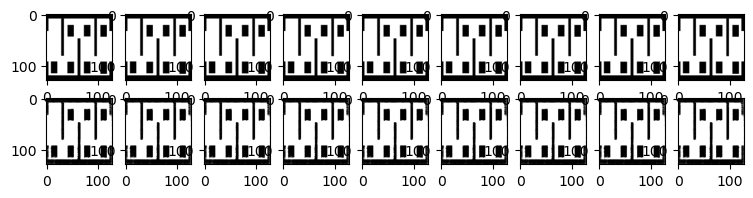

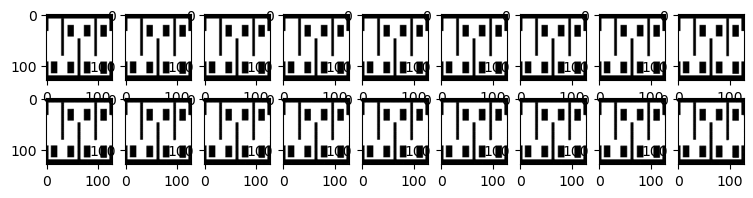

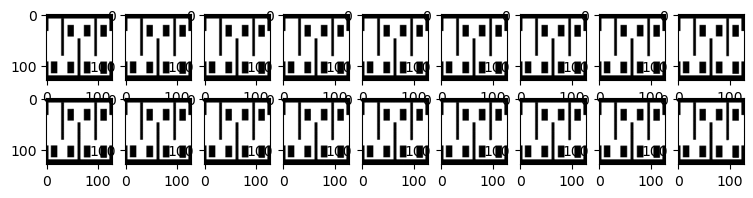

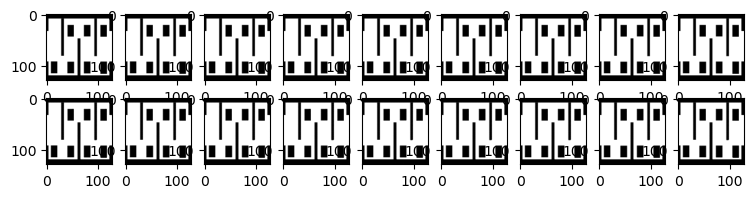

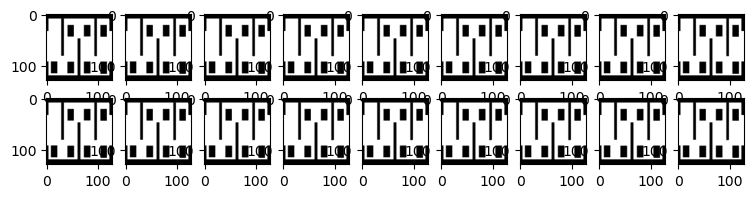

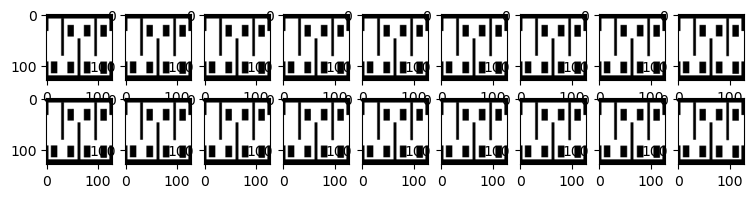

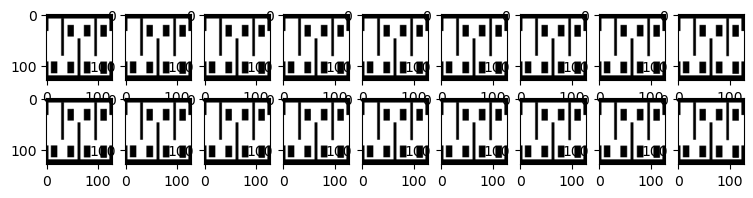

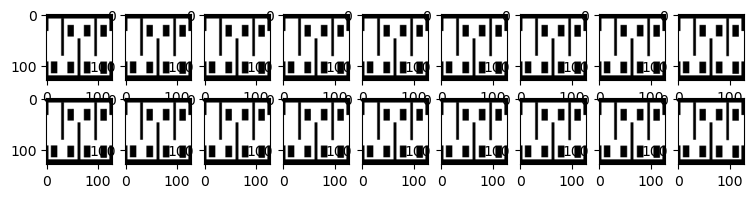

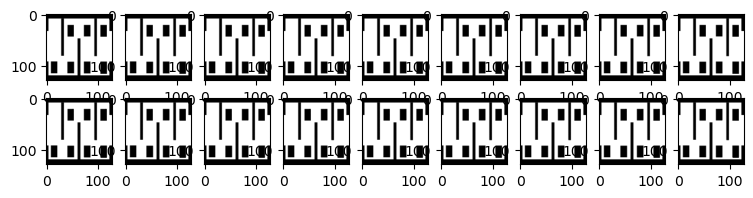

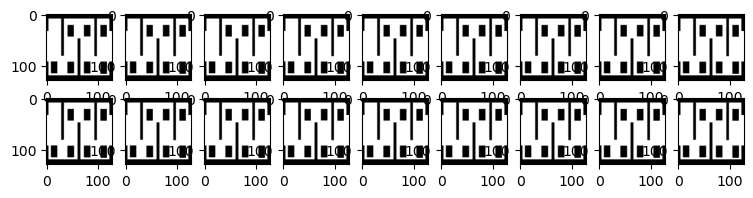

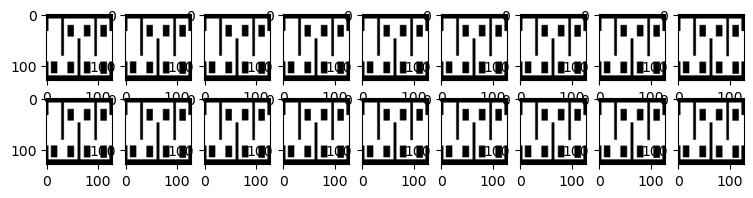

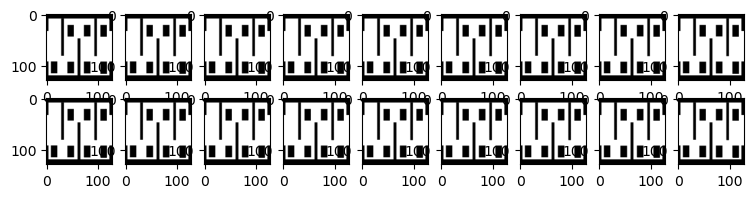

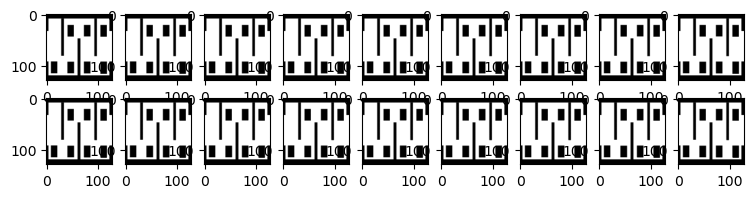

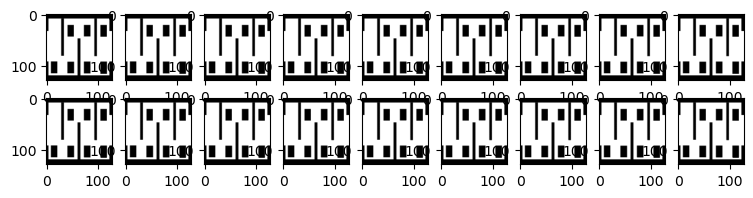

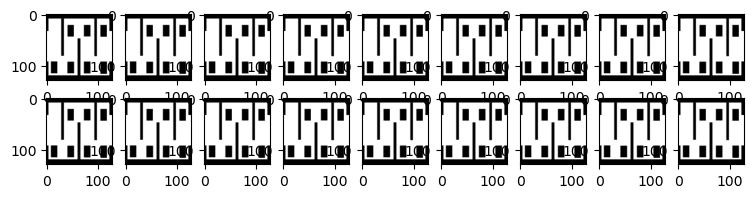

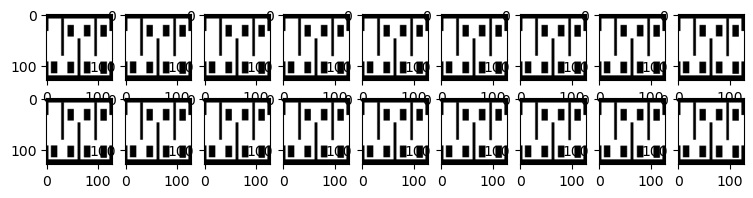

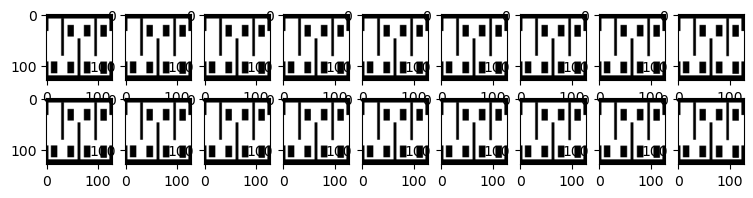

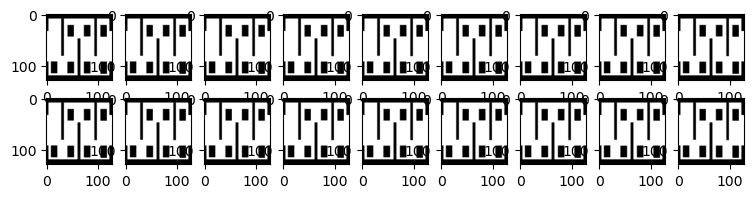

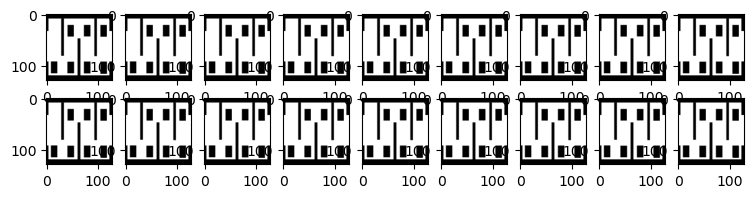

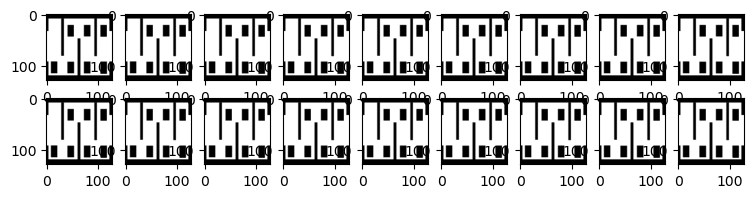

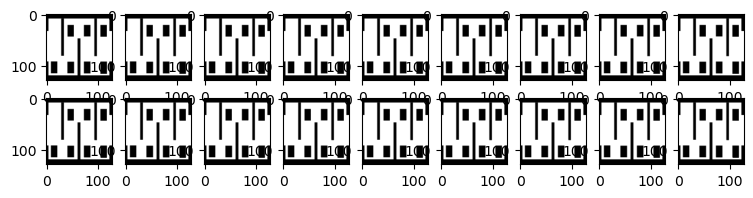

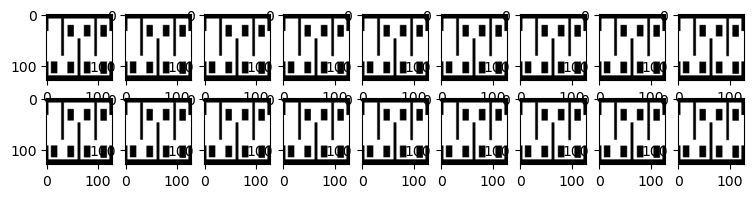

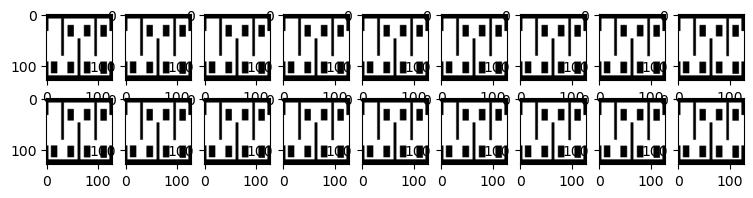

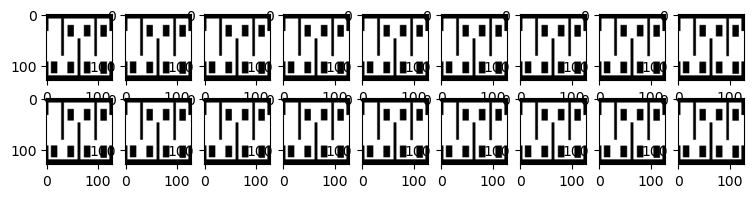

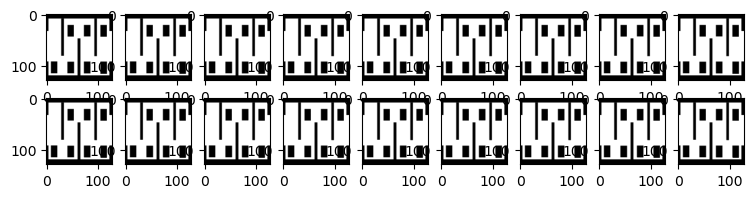

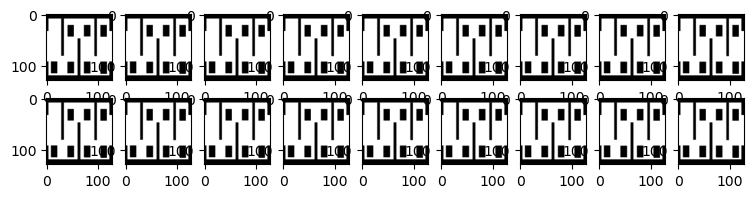

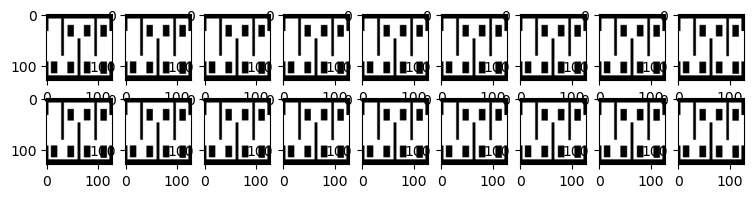

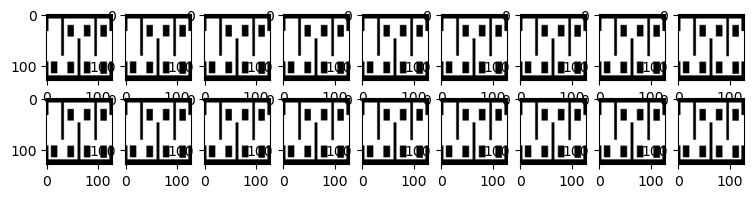

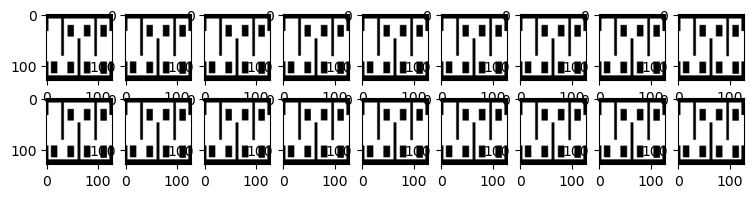

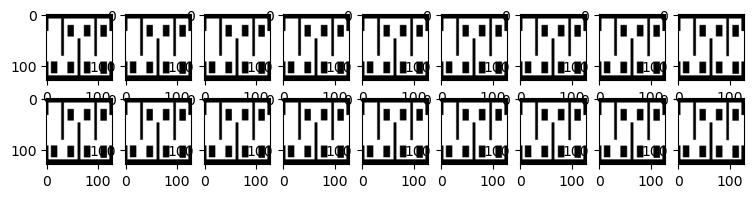

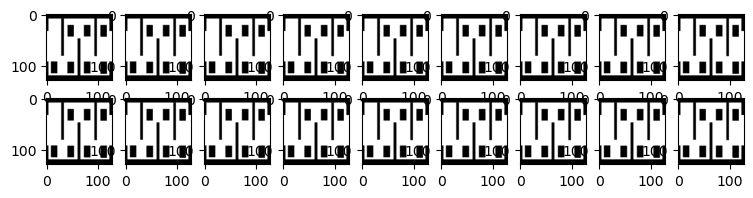

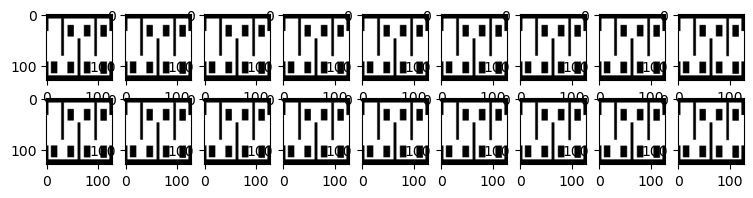

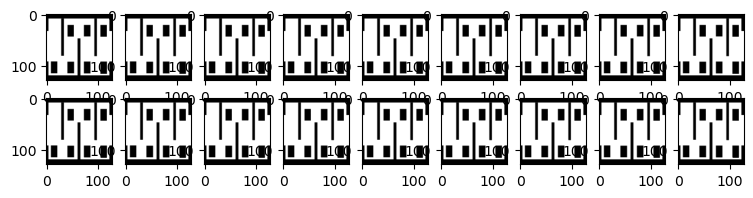

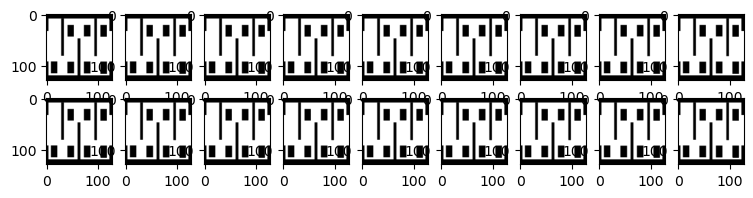

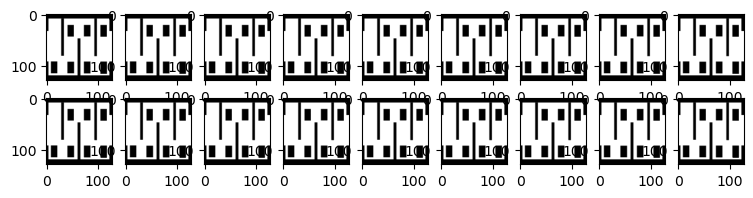

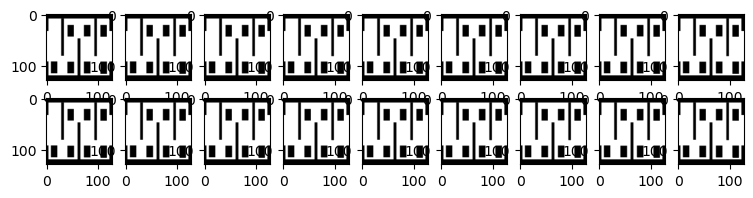

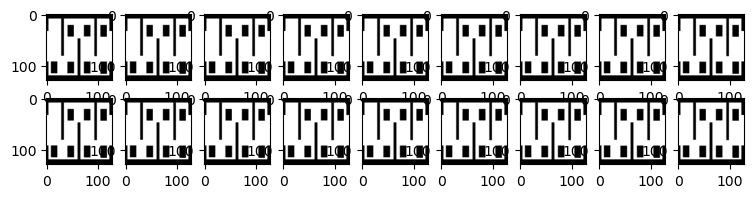

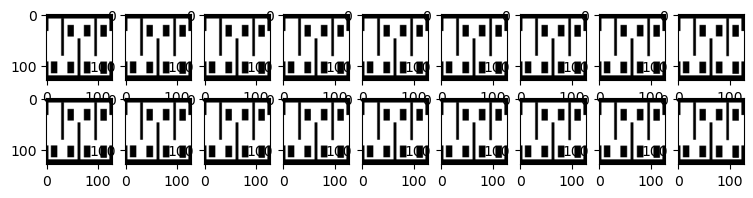

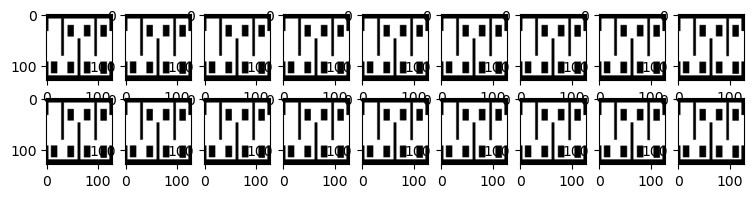

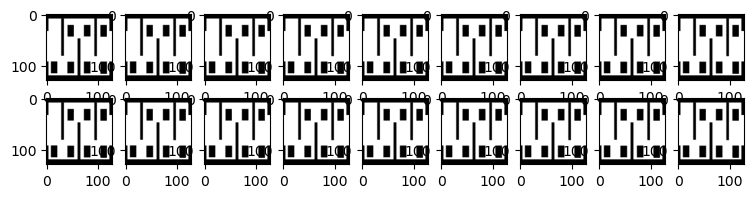

In [19]:
for k in range(0, 399, 10):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])